In [1]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
%pylab inline
import pandas as pd

merged = pd.read_csv("TableS4-WGSvsCapillary-combined.csv")
print("Number of loci before filtering: %s"%(len(set(merged["PrimerID"]))))

# Remove FXN, since no WGS calls
merged = merged[~merged["PrimerID"].isin(["FXN"])]
print("Number of loci after remove FXN: %s"%(len(set(merged["PrimerID"]))))

# Remove where we couldn't compare
merged = merged[merged["match.ensemble"].apply(str) != "nan"]
print("Number of loci after remove nan: %s"%(len(set(merged["PrimerID"]))))

# Get dosages and check matches
def GetDosage(x):
    if x == "." or x == "./.": return np.nan
    else: return sum([int(float(item)) for item in x.split(",")])
    
merged["dosage.ensemble"] = merged["Ensemble"].apply(GetDosage)
merged["dosage.cap"] = merged["Cap.Binned"].apply(GetDosage)
merged.sort_values("PrimerID").to_csv("TableS4-WGSvsCapillary-combined_comparable.csv", index=None)

Populating the interactive namespace from numpy and matplotlib
Number of loci before filtering: 49
Number of loci after remove FXN: 48
Number of loci after remove nan: 45


In [3]:
######## Output summary info ########
print("Number of loci: %s"%(len(set(merged["PrimerID"]))))
print("Number of samples: %s"%(len(set(merged["SampleID"]))))
print("Number of calls: %s"%(merged.shape[0]))

num_nonmissing = (merged[(merged["Ensemble"]!="./.") & (merged["Cap.Binned"]!= "./.")].shape[0])
num_correct = (np.sum(merged[(merged["Ensemble"]!="./.") & (merged["Cap.Binned"]!= "./.")]["match.ensemble"]))

num_nonmissing_hipstr = (merged[(merged["HipSTR"]!="./.") & (merged["Cap.Binned"]!= "./.")].shape[0])
num_correct_hipstr = (np.sum(merged[(merged["HipSTR"]!="./.") & (merged["Cap.Binned"]!= "./.")]["match.hipstr"]))

num_nonmissing_gangstr = (merged[(merged["GangSTR"]!="./.") & (merged["Cap.Binned"]!= "./.")].shape[0])
num_correct_gangstr = (np.sum(merged[(merged["GangSTR"]!="./.") & (merged["Cap.Binned"]!= "./.")]["match.gangstr"]))

print("Number of calls (not missing): %s"%num_nonmissing)
print("Number of correct: %s"%num_correct)
print("Concordance Ensemble: %s"%(num_correct/num_nonmissing))
print("Concordance GangSTR: %s"%(num_correct_gangstr/num_nonmissing_gangstr))
print("Concordance HipSTR: %s"%(num_correct_hipstr/num_nonmissing_hipstr))

Number of loci: 45
Number of samples: 31
Number of calls: 1395
Number of calls (not missing): 1395
Number of correct: 1362
Concordance Ensemble: 0.9763440860215054
Concordance GangSTR: 0.9559248554913294
Concordance HipSTR: 0.9762931034482759


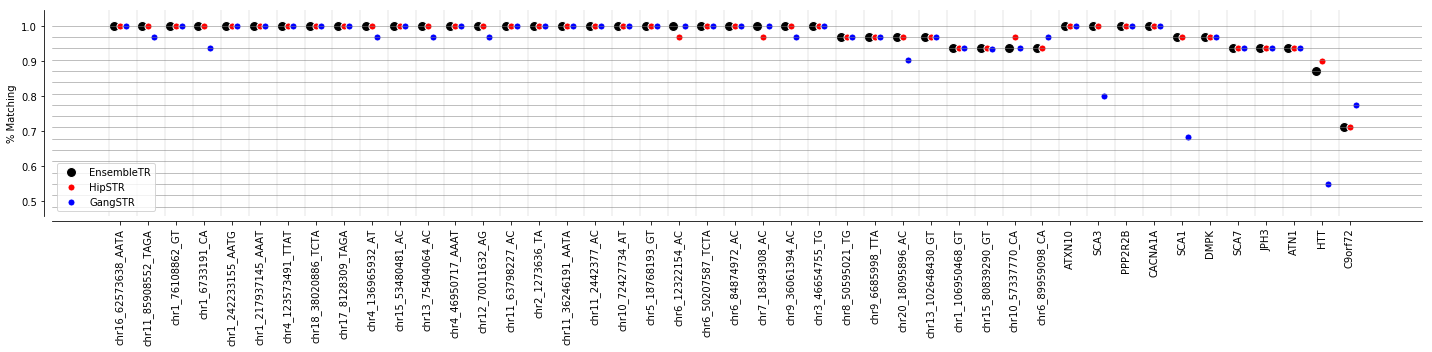

In [4]:
######## Per-locus accuracy ########
locdata = merged[merged["Ensemble"]!="./."].groupby(["PrimerID"], as_index=False).agg({"match.ensemble": np.sum, "SampleID": len})
locdata["ens.acc"] = locdata.apply(lambda x: x["match.ensemble"]/x["SampleID"], 1)
locdata = locdata.sort_values("ens.acc", ascending=False)

locdata_g = merged[merged["GangSTR"]!="./."].groupby(["PrimerID"], as_index=False).agg({"match.gangstr": np.sum, "SampleID": len})
locdata_g["gangstr.acc"] = locdata_g.apply(lambda x: x["match.gangstr"]/x["SampleID"], 1)
locdata_h = merged[merged["HipSTR"]!="./."].groupby(["PrimerID"], as_index=False).agg({"match.hipstr": np.sum, "SampleID": len})
locdata_h["hipstr.acc"] = locdata_h.apply(lambda x: x["match.hipstr"]/x["SampleID"], 1)

locdata = pd.merge(locdata, locdata_g[["PrimerID","gangstr.acc"]], how="left", on=["PrimerID"])
locdata = pd.merge(locdata, locdata_h[["PrimerID","hipstr.acc"]], how="left", on=["PrimerID"])
locdata["is.disease"] = locdata.apply(lambda x: x["PrimerID"].startswith("chr"), 1)
locdata = locdata.sort_values(["is.disease", "ens.acc"], ascending=False)

w = 0.2
fig = plt.figure()
fig.set_size_inches((20, 5))
ax = fig.add_subplot(111)
ax.scatter(range(locdata.shape[0]), locdata["ens.acc"], edgecolor="white", color='black', 
       label="EnsembleTR", s=100)
ax.scatter([item+w for item in range(locdata.shape[0])], locdata["hipstr.acc"], edgecolor="white", 
       color='red',label="HipSTR", s=50)
ax.scatter([item+2*w for item in range(locdata.shape[0])], locdata["gangstr.acc"], edgecolor="white", 
       color='blue', label="GangSTR", s=50)

for i in range((locdata.shape[0])):
    ax.axvline(x=i-w, linestyle="solid", color="gray", linewidth=0.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))
plt.rcParams['axes.linewidth']=0.8

ax.set_xticks([item+w for item in range(locdata.shape[0])])
ax.set_xticklabels(locdata["PrimerID"], rotation=90);
ax.set_ylabel("% Matching");
ax.legend(loc="lower left");

for num_corr in range(15, 32):
    ax.axhline(y=num_corr/31, linestyle="solid", color="gray", linewidth=0.5)
plt.tight_layout()
fig.savefig("pdfs/SuppFig-CapillaryLocusConcordance.pdf")

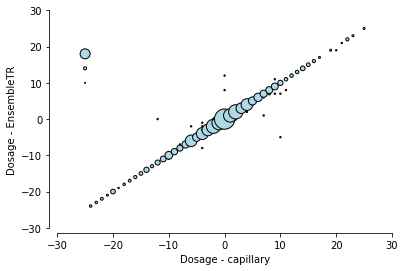

In [5]:
######## Bubbles ########

bubbles = merged[merged["Ensemble"]!="./."].groupby(["dosage.ensemble","dosage.cap"], as_index=False).agg({"SampleID": len})

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(bubbles["dosage.cap"], bubbles["dosage.ensemble"], 
           s=bubbles["SampleID"]*2, edgecolor="black", color="lightblue")
ax.scatter([-25, -25, -25], [10, 14, 18], s=[1, 10, 100], edgecolor="black", color="lightblue")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim(left=-30, right=30)
ax.set_ylim(bottom=-30, top=30);
ax.set_xlabel("Dosage - capillary")
ax.set_ylabel("Dosage - EnsembleTR");
fig.savefig("pdfs/SuppFig-CapillaryBubbles.pdf")

In [6]:
######## Inspect discordant calls ########
merged[(merged["Ensemble"]!="./.") & 
       (merged["match.ensemble"]==False)].sort_values("PrimerID")[["PrimerID","SampleID","Cap.Binned","GangSTR","HipSTR",
                                                                   "Ensemble"]].reset_index(drop=True)

,PrimerID,SampleID,Cap.Binned,GangSTR,HipSTR,Ensemble
0,ATN1,NA12892,"0,2","0,1","0,1","0,1"
1,ATN1,NA20506,"0,11","0,6","0,8","0,8"
2,C9orf72,NA19238,"2,3","3,3","1,3","1,3"
3,C9orf72,NA18942,"0,0","-1,-1","-1,-1","-1,-1"
4,C9orf72,NA18939,"-2,-2","-1,-1","-1,-1","-1,-1"
5,C9orf72,NA18488,"-1,11","-1,9","-1,8","-1,8"
6,C9orf72,NA12890,"-1,9","-1,8","-1,8","-1,8"
7,C9orf72,NA12889,"-1,9","-1,9","-1,8","-1,8"
8,C9orf72,NA12877,"-1,9","-1,8","-1,8","-1,8"
9,C9orf72,HG00766,"-1,10","-1,9","-1,8","-1,8"
